## Import packages

In [191]:
import cv2
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

import pytesseract
from pytesseract import Output

## Pre-define some global variables

In [192]:
BLUE = (255, 0, 0)
GREEN = (0, 255, 0)
RED = (0, 0, 255)

# IMAGE_PATH = 'Images/gauge-1.jpg'
IMAGE_PATH = 'Images/Dial_Indicator_2.jpg'

## Helper functions

### Show image functions

In [193]:
def show_image(image, scale=1):
    windowName = 'Image'
    if scale != 1:
        cv2.namedWindow(windowName, cv2.WINDOW_NORMAL)
        cv2.resizeWindow(windowName, int(scale*image.shape[1]), int(scale*image.shape[0]))
    cv2.imshow(windowName, image)
    cv2.waitKey(0) 
    cv2.destroyAllWindows() 



def show_image_notebook(image, scale=1, title="Image"):
    rgbImage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    width = rgbImage.shape[1]
    height = rgbImage.shape[0]

    if scale != 1:
        plt.figure(figsize=(round(width*scale), round(height*scale)))
    plt.title(title)
    plt.imshow(rgbImage)
    plt.show()  

### Math functions

In [194]:
def calculate_distance_between_two_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)


# Get the distance between point p0 and a line p1 p2
# Use the formula: Line defined by two points (https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line)
def calcualte_distance_between_point_and_line(p1, p2, p0):
    return np.abs(np.cross(p2-p1, p1-p0)) / calculate_distance_between_two_points(p1, p2)


def calculate_pointer_angle(circleCenter, furthestPoint):
    zeroPointTransform = np.array([0, -circleCenter[1]])
    furthestPointTransform = furthestPoint - circleCenter

    cosTheta = np.dot(furthestPointTransform, zeroPointTransform) / (LA.norm(furthestPointTransform) * LA.norm(zeroPointTransform))
    angleRadian = np.arccos(cosTheta)

    if furthestPointTransform[0] < 0:
        angleRadian = 2*np.pi - angleRadian

    return np.rad2deg(angleRadian)
    

def read_dial(angleDegree, maxReading, clockwise=True):
    reading = 0
    if clockwise:
        reading = maxReading * angleDegree/360
    else:
        reading = maxReading * (360-angleDegree)/360
    return np.around(reading, 2)
    



### Detect circle functions

In [195]:
def detect_circles(grayImage, width, height, minDistance, minR, maxR):
    minDistance = np.around(minDistance)
    minR = np.around(minR)
    maxR = np.around(maxR)

    # dp=1 The accumulator matrix has the same size as the image
    # minDist: The minimum distance between two detected circles
    # param1: Upper threshold for the internal Canny edge detector
    # param2: The accumulator threshold for the circle centers at the detection stage
    circles = cv2.HoughCircles(grayImage, cv2.HOUGH_GRADIENT, dp=1, minDist=minDistance, param1=200, param2=100, minRadius=minR, maxRadius=maxR)

    if circles is None:
        raise Exception("Cannot find any circles")

    return circles[0]



def draw_circles(image, circles):
    # `circles` is 2-D array
    resultImage = np.copy(image)
    for c in circles:
        centerX, centerY, radius = np.around(c).astype(int)
        # Draw the detected circle
        resultImage = cv2.circle(resultImage, (centerX, centerY), radius, GREEN, 2, cv2.LINE_AA)  
        # Draw the center
        resultImage = cv2.circle(resultImage, (centerX, centerY), 2, GREEN, 2, cv2.LINE_AA)  
    
    return resultImage



def get_average_circle(circles):
    # `circles` is 2-D array 
    averageCircle = np.average(circles, axis=0)
    return np.around(averageCircle).astype(int)

    



### Detect line functions

In [196]:
def detect_lines(grayImage, minLength, maxGap, cannyParam1=100, cannyParam2=200):
    # _, thresholdResultmage = cv2.threshold(grayImage, thresh=100, maxval=255, type=cv2.THRESH_BINARY_INV)

    cannyEdgeImage = cv2.Canny(grayImage, threshold1=cannyParam1, threshold2=cannyParam2)
    show_image_notebook(cannyEdgeImage, scale=1, title='Canny Edge')

    # rho: Distance resolution of the accumulator in pixels
    # theta: Angle resolution of the accumulator in radians
    # threshold: Accumulator threshold parameter
    # minLineLength: Minimum line length
    # maxLineGap: Maximum allowed gap between points on the same line
    lines = cv2.HoughLinesP(cannyEdgeImage, rho=1, theta=np.pi/180, threshold=100, minLineLength=minLength, maxLineGap=maxGap)

    if lines is None:
        raise Exception("Cannot find any lines")
    
    return np.squeeze(lines)



# Only the lines whose distance to the circle center is less than or equal to the threshold are valid
def filter_lines(lines, threshold, center):
    validLines = []
    for l in lines:
        p1 = np.array([l[0], l[1]])
        p2 = np.array([l[2], l[3]])

        distance = calcualte_distance_between_point_and_line(p1, p2, center)
        if distance <= threshold:
            validTwoPoints = np.array([p1, p2])
            validLines.append(validTwoPoints)

    return np.stack(validLines)



def draw_lines(image, lines):
    resultImage = np.copy(image)
    for l in lines:
        p1 = l[0]
        p2 = l[1]
        cv2.line(resultImage, (p1[0], p1[1]), (p2[0], p2[1]), GREEN, 2, cv2.LINE_AA)
    return resultImage


    

### Find the furthest point functions

In [197]:
def find_furthest_point(validLines, center):
    validPoints = validLines.reshape((validLines.shape[0]*validLines.shape[1], validLines.shape[2]))
    transformResult = validPoints - center
    
    distanceArray = LA.norm(transformResult, axis=1)

    furthestPointTransform = transformResult[distanceArray.argmax()]
    furthestPoint = furthestPointTransform + center

    return np.around(furthestPoint).astype(int)


def draw_point(image, point):
    resultImage = np.copy(image)
    resultImage = cv2.circle(resultImage, (point[0], point[1]), 3, GREEN, 3, cv2.LINE_AA) 
    return resultImage

## Load gauge images

The size of the image: Height: [4032] px, Width: [3024] px


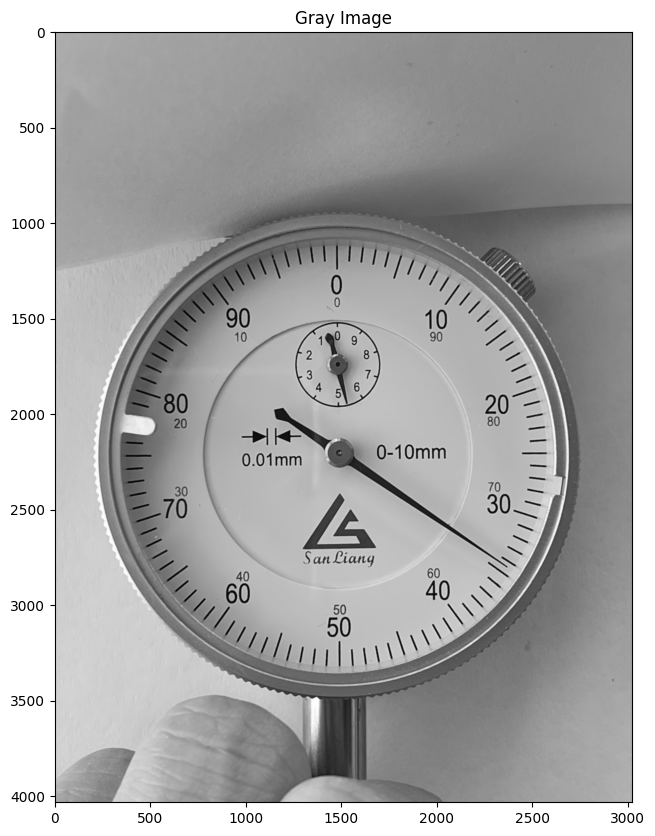

In [198]:
image = cv2.imread(IMAGE_PATH)
originalHeight, originalWidth = image.shape[0:2]
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
grayImage = cv2.GaussianBlur(grayImage, (7,7), 1.5, 1.5)

print(f"The size of the image: Height: [{originalHeight}] px, Width: [{originalWidth}] px")

show_image_notebook(grayImage, scale=1/400, title='Gray Image')



## Detect the circle of the dial

[[1484.5 2223.5 1202.7]
 [1482.5 2220.5 1205.8]
 [1482.5 2222.5 1193.2]
 ...
 [1403.5 2223.5 1176.9]
 [1427.5 2206.5 1200.6]
 [1576.5 2266.5 1033.6]]


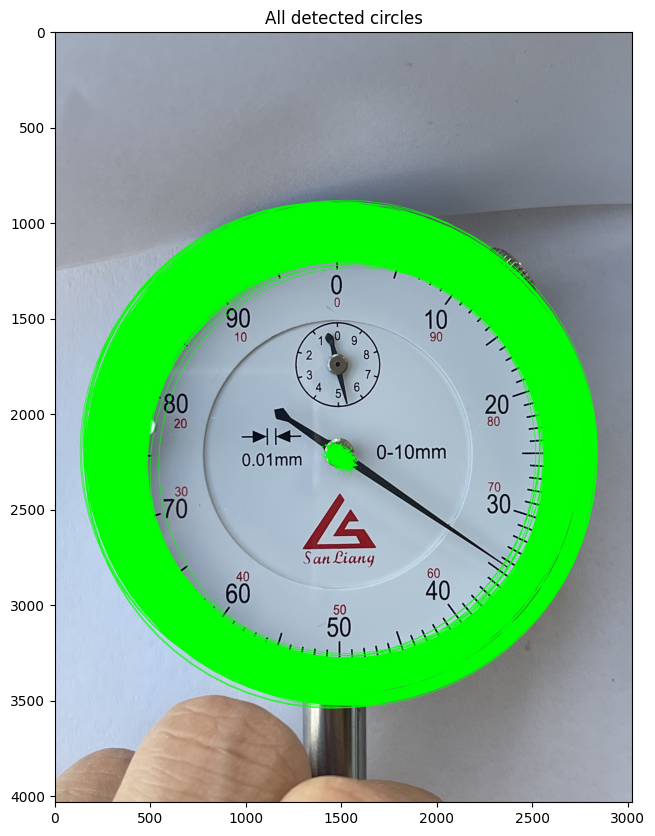

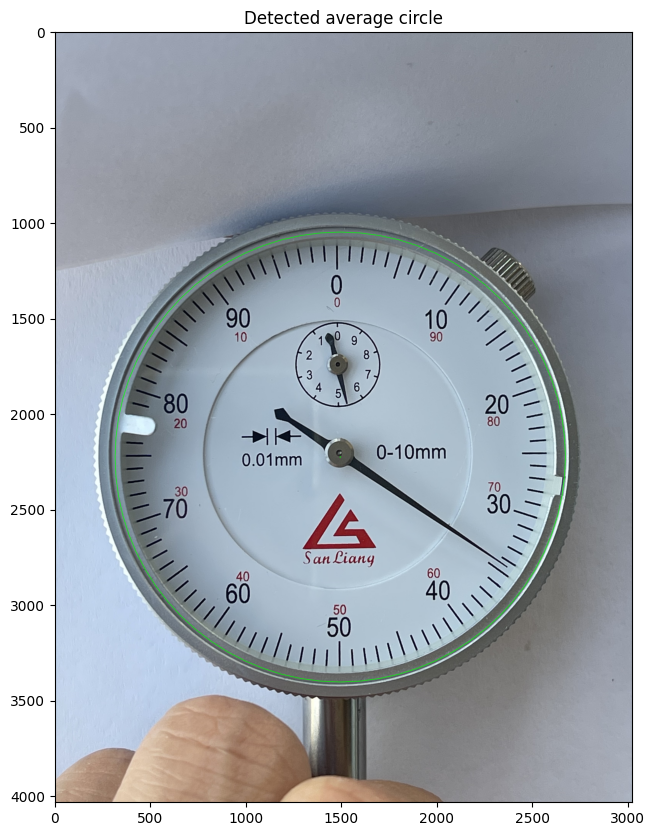

In [199]:
minDistance = round(1)
minR = round(originalWidth/4)

# minDistance = 1
# minR = 10

maxR = round(originalWidth/2)
circles = detect_circles(grayImage, originalWidth, originalHeight, minDistance, minR, maxR)

print(circles)

allDetectCircleResult = draw_circles(image, circles)
show_image_notebook(allDetectCircleResult, scale=1/400, title='All detected circles')



averageCircle = get_average_circle(circles)
detectCircleResult = draw_circles(image, np.array([averageCircle]))
show_image_notebook(detectCircleResult, scale=1/400, title='Detected average circle')


## Crop the image

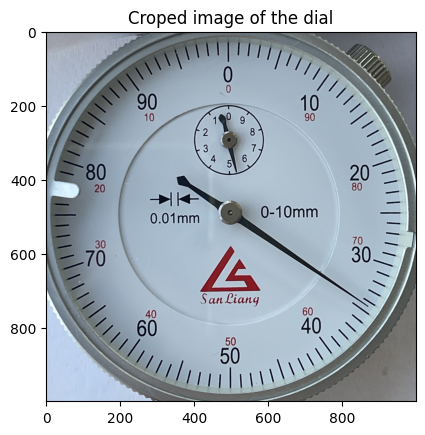

In [200]:
centerX, centerY, radius = averageCircle
padding = 0

upperLeft = (centerX-(radius+padding), centerY-(radius+padding))
lowerRight = (centerX+(radius+padding), centerY+(radius+padding))


dialImage = image[upperLeft[1] : (lowerRight[1]+1), upperLeft[0] : (lowerRight[0]+1)]
dialImage = cv2.resize(dialImage, (1000, 1000))
dialGrayImage = cv2.cvtColor(dialImage, cv2.COLOR_BGR2GRAY)

show_image_notebook(dialImage, scale=1, title='Croped image of the dial')

# dialGrayImage = cv2.GaussianBlur(dialGrayImage, (7,7), 1.5, 1.5)

# dialGrayImage = grayImage[upperLeft[1] : (lowerRight[1]+1), upperLeft[0] : (lowerRight[0]+1)]
# dialGrayImage = cv2.resize(dialGrayImage, (1000, 1000))



## Detect the line of the pointer

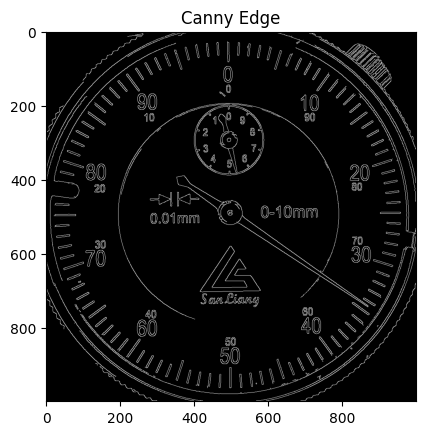

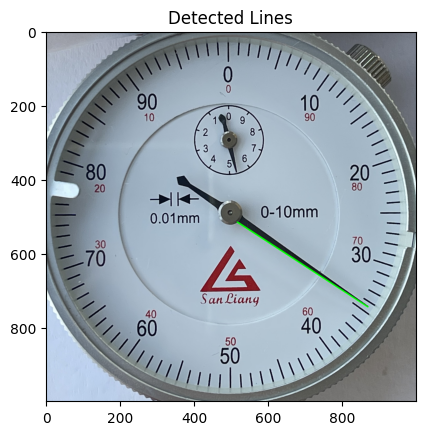

In [201]:
dialHeight, dialWidth = dialGrayImage.shape
center = np.around(np.array([dialWidth, dialHeight]) / 2).astype(int)

minLength = dialWidth // 4
maxGap = 5
lines = detect_lines(dialGrayImage, minLength, maxGap, cannyParam1=100, cannyParam2=200)


threshold = 10
validLines = filter_lines(lines, threshold, center)


detectLineResult = draw_lines(dialImage, validLines)

show_image_notebook(detectLineResult, scale=1, title='Detected Lines')


## Find the furthest point

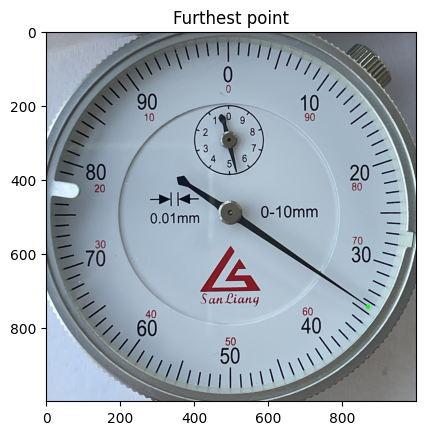

In [202]:
furthestPoint = find_furthest_point(validLines, center)

furthestPointResult = draw_point(dialImage, furthestPoint)

show_image_notebook(furthestPointResult, scale=1, title='Furthest point')


## Calculate the angle

The pointer is at [123.5110187978408] degree


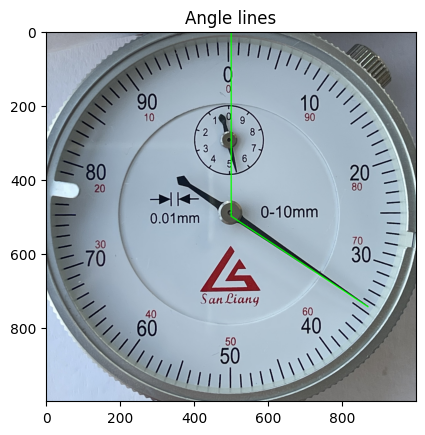

In [203]:
angleDegree = calculate_pointer_angle(center, furthestPoint)
print(f"The pointer is at [{angleDegree}] degree")

zeroLine = np.array([center, [center[0], 0]])
needleLine = np.array([center, furthestPoint])

angleResult = draw_lines(dialImage, np.array([zeroLine, needleLine]))
show_image_notebook(angleResult, scale=1, title='Angle lines')




## Read the dial

The reading of the gauge is [34.31].


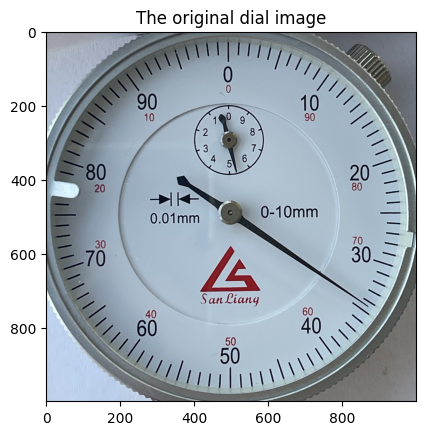

In [204]:
maxReading = 100
bigDialReading = read_dial(angleDegree, maxReading)

print(f"The reading of the gauge is [{bigDialReading}].")
show_image_notebook(dialImage, scale=1, title='The original dial image')


# Combine those in to a big function

In [205]:
def read_dial_indicator(imagePath, imageOutPath, circleMinDistance, circleMinRDivWidth, circleMaxRDivWidth, lineMinLengthDivWidth, lineMaxGap, lineDistanceThreshold, lineCannyParam1, lineCannyParam2, maxReading, clockwise=True):
    # ==================================================
    # Load image and preprocess the image
    # ==================================================
    image = cv2.imread(imagePath)
    originalHeight, originalWidth = image.shape[0:2]
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayImage = cv2.GaussianBlur(grayImage, (7,7), 1.5, 1.5)

    print(f"The size of the image: Height: [{originalHeight}] px, Width: [{originalWidth}] px")
    show_image_notebook(grayImage, scale=1/200, title='Pre-processed Gray Image')


    # ==================================================
    # Detect the circle
    # ==================================================
    minDistance = round(circleMinDistance)
    minR = round(originalWidth*circleMinRDivWidth)
    maxR = round(originalWidth*circleMaxRDivWidth)
    circles = detect_circles(grayImage, originalWidth, originalHeight, minDistance, minR, maxR)

    print(circles)

    allDetectCircleResult = draw_circles(image, circles)
    show_image_notebook(allDetectCircleResult, scale=1/200, title='All detected circles')

    averageCircle = get_average_circle(circles)
    detectCircleResult = draw_circles(image, np.array([averageCircle]))
    show_image_notebook(detectCircleResult, scale=1/200, title='Detected average circle')


    # ==================================================
    # Crop the image
    # ==================================================
    centerX, centerY, radius = averageCircle
    padding = 0

    upperLeft = (centerX-(radius+padding), centerY-(radius+padding))
    lowerRight = (centerX+(radius+padding), centerY+(radius+padding))


    dialImage = image[upperLeft[1] : (lowerRight[1]+1), upperLeft[0] : (lowerRight[0]+1)]
    dialImage = cv2.resize(dialImage, (1000, 1000))
    dialGrayImage = cv2.cvtColor(dialImage, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(imageOutPath, dialImage)
    

    show_image_notebook(dialImage, scale=1, title='Croped image of the dial')


    # ==================================================
    # Detect lines of the needle
    # ==================================================
    dialHeight, dialWidth = dialGrayImage.shape
    center = np.around(np.array([dialWidth, dialHeight]) / 2).astype(int)

    minLength = round(dialWidth*lineMinLengthDivWidth)
    maxGap = round(lineMaxGap)
    lines = detect_lines(dialGrayImage, minLength, maxGap, cannyParam1=lineCannyParam1, cannyParam2=lineCannyParam2)

    print(lines)

    validLines = filter_lines(lines, lineDistanceThreshold, center)
    detectLineResult = draw_lines(dialImage, validLines)

    show_image_notebook(detectLineResult, scale=1, title='Detected Lines')


    # ==================================================
    # Find the furthest point
    # ==================================================
    furthestPoint = find_furthest_point(validLines, center)
    furthestPointResult = draw_point(dialImage, furthestPoint)

    show_image_notebook(furthestPointResult, scale=1, title='Furthest point')


    # ==================================================
    # Calculate the angle
    # ==================================================
    angleDegree = calculate_pointer_angle(center, furthestPoint)
    print(f"The pointer is at [{angleDegree}] degree")

    zeroLine = np.array([center, [center[0], 0]])
    needleLine = np.array([center, furthestPoint])

    angleResult = draw_lines(dialImage, np.array([zeroLine, needleLine]))
    show_image_notebook(angleResult, scale=1, title='Angle lines')


    # ==================================================
    # Read the dial
    # ==================================================
    dialReading = read_dial(angleDegree, maxReading, clockwise)

    print(f"The reading of the gauge is [{dialReading}].")
    show_image_notebook(dialImage, scale=1, title='The original dial image')

    return dialReading






# Big dial reading

The size of the image: Height: [4032] px, Width: [3024] px


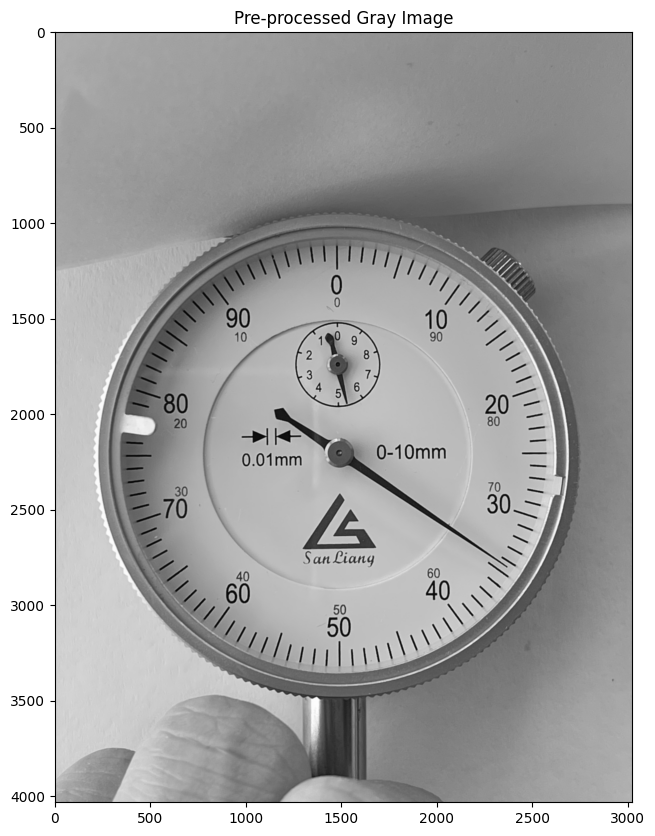

[[1484.5 2223.5 1202.7]
 [1482.5 2220.5 1205.8]
 [1482.5 2222.5 1193.2]
 ...
 [1403.5 2223.5 1176.9]
 [1427.5 2206.5 1200.6]
 [1576.5 2266.5 1033.6]]


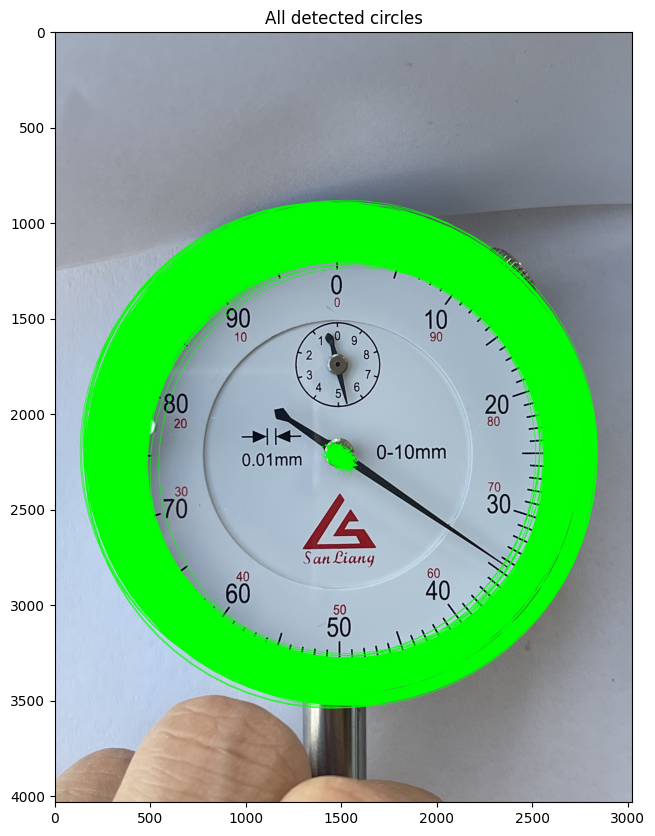

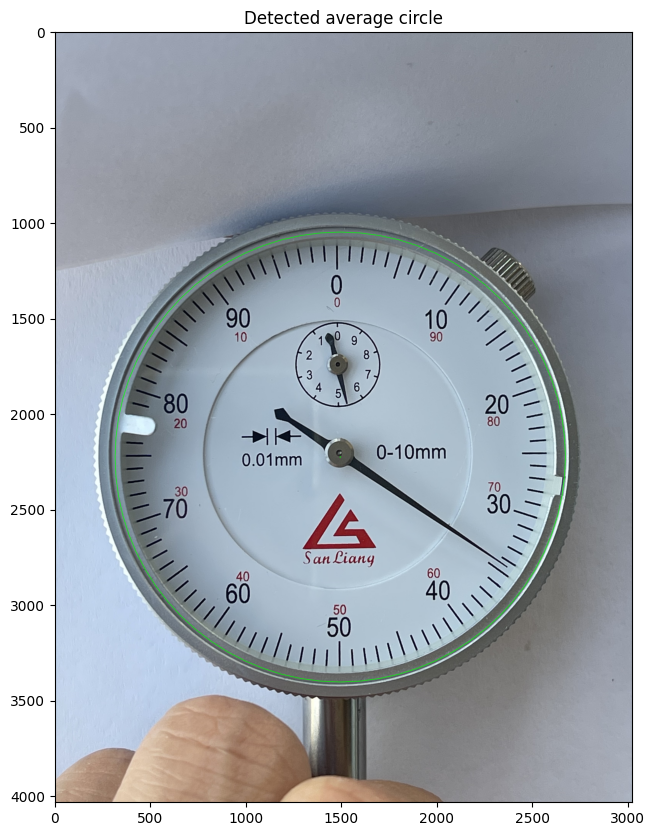

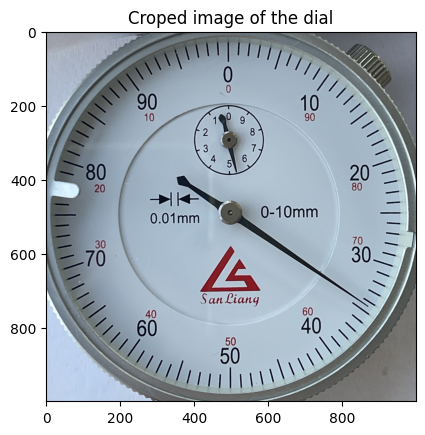

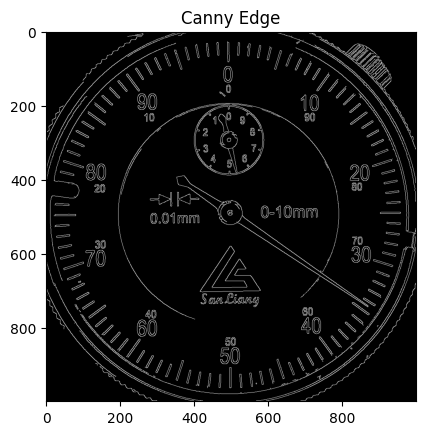

[[518 516 870 745]
 [516 516 869 745]]


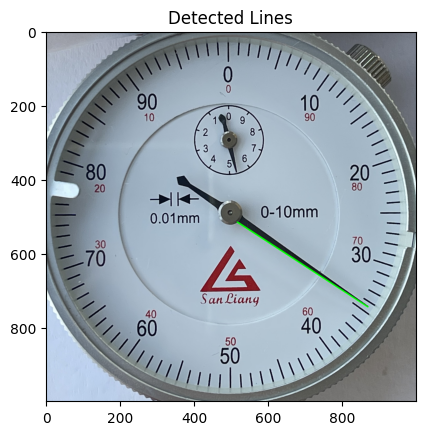

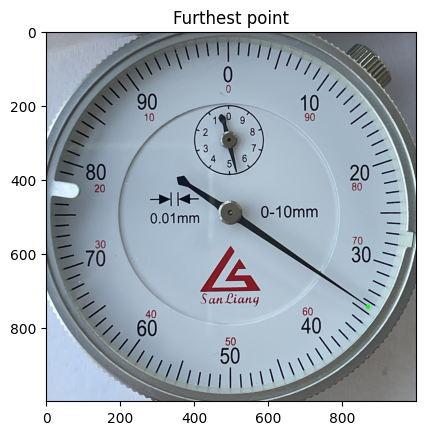

The pointer is at [123.5110187978408] degree


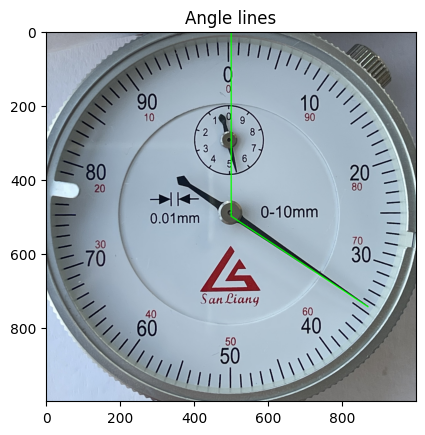

The reading of the gauge is [34.31].


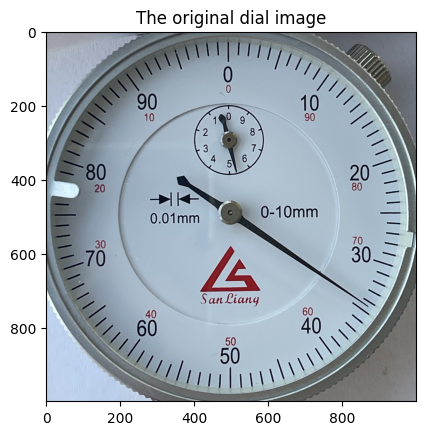

In [206]:
imagePath = 'Images/Dial_Indicator_2.jpg'
imageOutPath = 'Images/Dial_Indicator_2_dial_only.jpg'


dialReading = read_dial_indicator(imagePath, imageOutPath, circleMinDistance=1, circleMinRDivWidth=0.25, circleMaxRDivWidth=0.5, lineMinLengthDivWidth=0.25, lineMaxGap=5, lineDistanceThreshold=10, lineCannyParam1=100, lineCannyParam2=200, maxReading=100, clockwise=True)

# Read the revolution counter

The size of the image: Height: [1000] px, Width: [1000] px


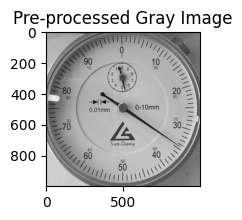

[[493.5 294.5  94.5]
 [494.5 293.5  91.4]
 [494.5 295.5  94.2]
 [495.5 296.5  93.3]
 [491.5 295.5  93.3]
 [490.5 297.5  95.2]
 [496.5 299.5  89.8]
 [497.5 290.5  90. ]
 [488.5 290.5  88.8]
 [498.5 291.5  90. ]
 [497.5 298.5  89.5]
 [499.5 300.5  86.8]]


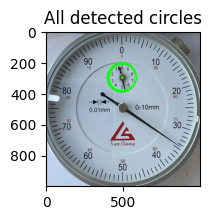

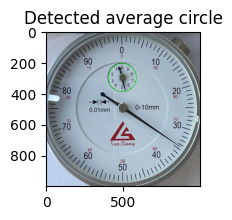

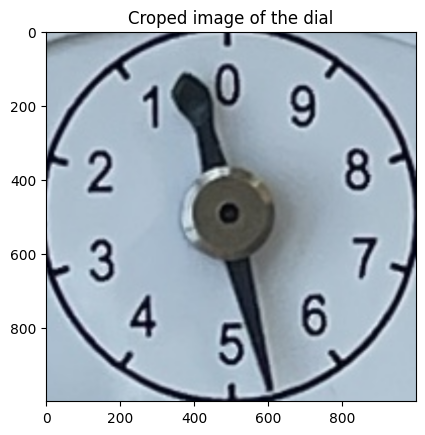

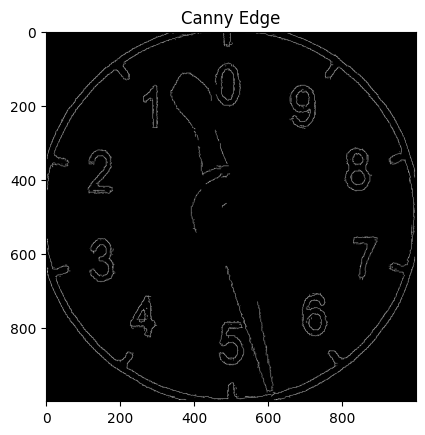

[[635   4 657   4]
 [545 813 600 982]
 [527 762 545 816]
 [506 169 506 116]
 [539   4 581   4]]


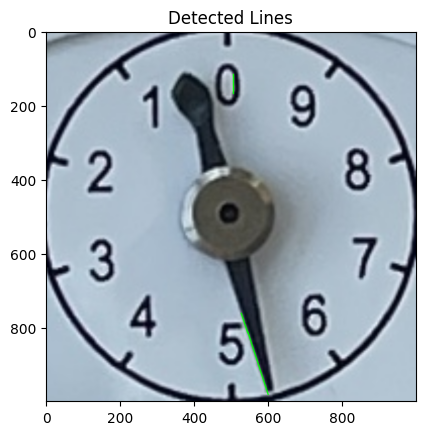

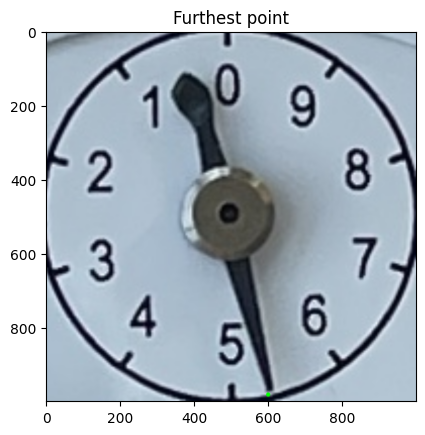

The pointer is at [168.27918850119053] degree


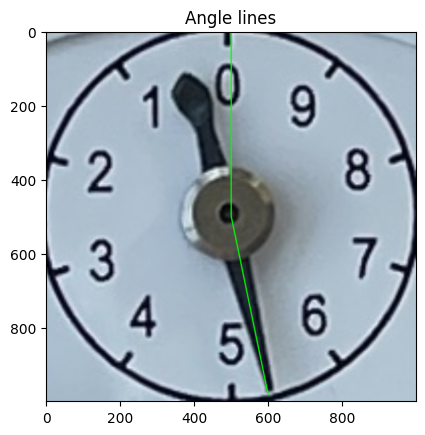

The reading of the gauge is [5.33].


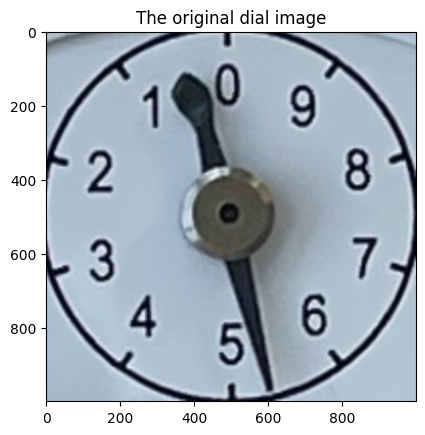

In [207]:
dialOnlyImagePath = 'Images/Dial_Indicator_2_dial_only.jpg'
dialOnlyImageOutPath = 'Images/Dial_Indicator_2_revoluton_counter.jpg'


revolutionCounter = read_dial_indicator(dialOnlyImagePath, dialOnlyImageOutPath, circleMinDistance=1, circleMinRDivWidth=0.01, circleMaxRDivWidth=0.3, lineMinLengthDivWidth=0.01, lineMaxGap=10, lineDistanceThreshold=100, lineCannyParam1=70, lineCannyParam2=140, maxReading=10, clockwise=False)

revolutionCounter = np.floor(revolutionCounter)

# Final result

The final reading of the dial is [534.31].


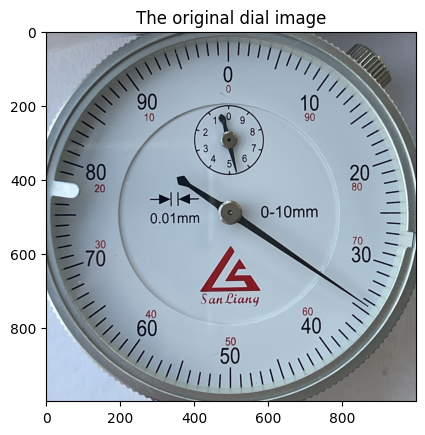

In [208]:
finalResult = revolutionCounter * 100 + dialReading
print(f"The final reading of the dial is [{finalResult}].")



dialOnlyImage = cv2.imread(dialOnlyImagePath)

show_image_notebook(dialOnlyImage, scale=1, title='The original dial image')

In [209]:



# dialGrayImage = cv2.medianBlur(dialGrayImage, 9)
# dialGrayImage = cv2.GaussianBlur(dialGrayImage, (5, 5), 0)
# show_image(dialGrayImage)

# _, thresholdResultmage = cv2.threshold(dialGrayImage, thresh=150, maxval=255, type=cv2.THRESH_BINARY_INV)

# cannyEdgeDetectionResult = cv2.Canny(dialGrayImage, threshold1=50, threshold2=200, apertureSize=3, L2gradient=True)

# show_image(thresholdResultmage)

# rho: Distance resolution of the accumulator in pixels
# theta: Angle resolution of the accumulator in radians
# threshold: Accumulator threshold parameter
# minLineLength: Minimum line length
# maxLineGap: Maximum allowed gap between points on the same line
# lines = cv2.HoughLinesP(thresholdResultmage, rho=1, theta=np.pi/180, threshold=100, minLineLength=dialWidth//4, maxLineGap=0)





# print(lines)

# lines = np.squeeze(lines)
# print(lines)


# if lines is None:
#     raise Exception("Cannot find any lines")


# # assert(False)
# validLines = []
# distanceThreshold = 5
# for l in lines:
#     aLine = l[0]
#     p1 = np.array(aLine[:2])
#     p2 = np.array(aLine[2:])
   
#     distance = calcualte_distance_between_point_and_line(p1, p2, center)

#     if distance <= distanceThreshold:
#         # validTwoPoints = np.concatenate((p1, p2))
#         validTwoPoints = np.array([p1, p2])
#         validLines.append(validTwoPoints)

# print(validLines)


# validLines = np.stack(validLines)

  



# detectLineResult = draw_lines(detectLineResult, validLines)
# show_image(detectLineResult)

In [210]:
# # cannyEdgeImage = cv2.Canny(dialGrayImage, threshold1=100, threshold2=200)

# _, thresholdResultmage = cv2.threshold(dialGrayImage, thresh=15, maxval=255, type=cv2.THRESH_BINARY_INV)



# dialHeight, dialWidth = dialGrayImage.shape
# center = np.around(np.array([dialWidth, dialHeight]) / 2).astype(int)

# minLength = 1
# maxGap = 0
# lines = detect_lines(thresholdResultmage, minLength, maxGap)

# threshold = 1000
# validLines = filter_lines(lines, threshold, center)

# detectLineResult = draw_lines(dialImage, validLines)

# show_image_notebook(detectLineResult)


# # for l in lines:
# #     p1 = l[0]
# #     p2 = l[1]
# #     cv2.line(resultImage, (p1[0], p1[1]), (p2[0], p2[1]), GREEN, 2, cv2.LINE_AA)


# # thresholdResultmage = cv2.rotate(thresholdResultmage, cv2.ROTATE_90_CLOCKWISE)



# show_image_notebook(thresholdResultmage)

# # print(pytesseract.get_languages(config=''))

# text = pytesseract.image_to_data(thresholdResultmage, lang="eng", config="--psm 11 --oem 3 -c tessedit_char_whitelist=0123456789", output_type=Output.DICT)
# # text = pytesseract.image_to_boxes(thresholdResultmage, lang="eng", config='--psm 11 --oem 1')
# # print(text)
# print(text['text'])

# result = np.copy(dialImage)
# # result = cv2.rotate(result, cv2.ROTATE_90_CLOCKWISE)

# for i in range(len(text['text'])):
#     upperLeftX = text['left'][i]
#     upperLeftY = text['top'][i]
#     width = text['width'][i]
#     height = text['height'][i]
#     lowerRightX = upperLeftX + width
#     lowerRightY = upperLeftY + height

#     result = cv2.rectangle(result, (int(upperLeftX), int(upperLeftY)), (int(lowerRightX), int(lowerRightY)), GREEN, 2, cv2.LINE_AA)




# if '0' in text['text']:
#     index = text['text'].index('0')

#     print(index)

#     upperLeftX = text['left'][index]
#     upperLeftY = text['top'][index]
#     width = text['width'][index]
#     height = text['height'][index]
#     lowerRightX = upperLeftX + width
#     lowerRightY = upperLeftY + height




#     # result = np.copy(dialImage)
#     result = cv2.rectangle(result, (int(upperLeftX), int(upperLeftY)), (int(lowerRightX), int(lowerRightY)), RED, 3, cv2.LINE_AA)

# # for line in text.split('\n'):
# #     line = line.split(' ')
# #     if line[0] == '0':
# #         upperLeftX, upperLeftY, lowerRightX, lowerRightY = line[1:5]
# #         print(line)

# #         result = cv2.rectangle(result, (int(upperLeftX), int(upperLeftY)), (int(lowerRightX), int(lowerRightY)), GREEN, 2, cv2.LINE_AA)


# show_image_notebook(result)

# # boxes = pytesseract.image_to_string(image) 
# # print(boxes)